In [1]:
import pandas as pd
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
main_dir = "drive/MyDrive/dataset/"

In [ ]:
final_df = pd.read_csv(main_dir + 'final_data_new_regency.csv')
final_df.head()

In [ ]:
final_df.describe()

# Clustering DBScan

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the columns that need to be scaled and encoded
num_cols = ['total_guest_capacity', 'bedroom', 'bathroom', 'beds', 'avg_price_per_day', 'area_distance_to_airport']
cat_cols = ['property_type', 'area_regency_city']

# Create the transformers
scaler = MinMaxScaler()
encoder = OneHotEncoder(drop='first')

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols)
    ])

eps_value = 1.15
min_samples_value = 3
# Define the DBSCAN clustering algorithm
cluster = DBSCAN(eps=eps_value, min_samples=min_samples_value)  # You may need to tune these parameters

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('cluster', cluster)])

# Fit the pipeline
pipeline.fit(final_df)

# Get cluster labels and add them to the DataFrame
cluster_labels = pipeline.named_steps['cluster'].labels_
final_df['cluster_label'] = cluster_labels

print(final_df[['unit_id', 'cluster_label']])

    unit_id  cluster_label
0    UN0165              0
1    UN1536              0
2    UN1537              0
3    UN1538              0
4    UN1539              0
..      ...            ...
368  UN3099              2
369  UN3100              2
370  UN3101              2
371  UN3102              2
372  UN3103              2

[373 rows x 2 columns]


In [6]:
from sklearn.metrics import silhouette_score

X_transformed = pipeline.named_steps['preprocessor'].transform(final_df)

# Calculate the Silhouette score
# Note: Silhouette score can only be calculated if there are more than 1 cluster.
if len(set(cluster_labels)) > 1:
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print("Silhouette Score cannot be calculated with less than 2 clusters.")

Silhouette Score: 0.8307818702612887


In [7]:
from sklearn.metrics import davies_bouldin_score

# Asumsikan pipeline dan final_df sudah didefinisikan sebelumnya
X_transformed = pipeline.named_steps['preprocessor'].transform(final_df)

# Gunakan DBSCAN untuk menghasilkan cluster_labels

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
cluster_labels = dbscan.fit_predict(X_transformed)

# Hitung Davies-Bouldin Index
# Note: Davies-Bouldin Index can only be calculated if there are more than 1 cluster.
if len(set(cluster_labels)) > 1:
    davies_bouldin_avg = davies_bouldin_score(X_transformed, cluster_labels)
    print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
else:
    print("Davies-Bouldin Index cannot be calculated with less than 2 clusters.")

Davies-Bouldin Index: 0.7985988384502066


In [8]:
from sklearn.metrics import davies_bouldin_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN

def optimize_dbscan(X_transformed, eps_values, min_samples_values):
    best_dbi = np.inf
    best_params = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X_transformed)

            # Check jika lebih dari 1 cluster yang terbentuk
            if len(set(cluster_labels)) > 1:
                dbi = davies_bouldin_score(X_transformed, cluster_labels)
                if dbi < best_dbi:
                    best_dbi = dbi
                    best_params = (eps, min_samples)

    return best_dbi, best_params

# Transformasi data menggunakan preprocessor yang sudah didefinisikan
X_transformed = pipeline.named_steps['preprocessor'].transform(final_df)

# Daftar nilai eps dan min_samples yang ingin diuji
eps_values = [0.5, 1.0, 1.15, 1.5, 2.0]
min_samples_values = [3, 5, 10]

# Cari parameter terbaik
best_dbi, best_params = optimize_dbscan(X_transformed, eps_values, min_samples_values)

print(f'Best Davies-Bouldin Index: {best_dbi}')
print(f'Best Parameters: eps={best_params[0]}, min_samples={best_params[1]}')

Best Davies-Bouldin Index: 0.7985988384502066
Best Parameters: eps=1.15, min_samples=3


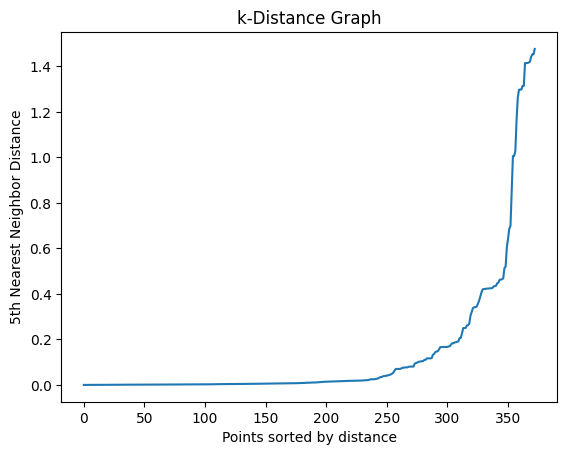

In [9]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit the model
neighbors = NearestNeighbors(n_neighbors=5)  # k is usually chosen as min_samples
neighbors_fit = neighbors.fit(X_transformed)
distances, indices = neighbors_fit.kneighbors(X_transformed)

# Sort and plot the distances
distances = np.sort(distances, axis=0)
distances = distances[:, 4]  # 4th column because we chose n_neighbors=5
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('k-Distance Graph')
plt.show()

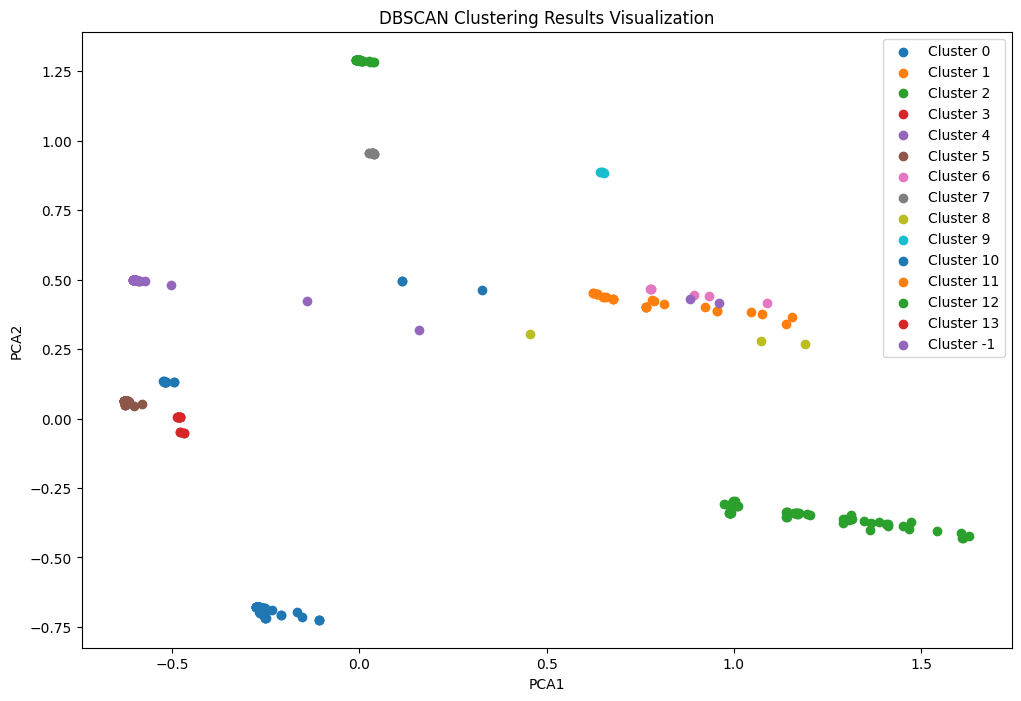

In [10]:
# For visualization, perform PCA to reduce dimensions to 2D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Transform the data using the preprocessor
X_transformed = pipeline.named_steps['preprocessor'].transform(final_df)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_transformed)

# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster_label'] = cluster_labels

# Plotting the PCA results with cluster labels
plt.figure(figsize=(12, 8))
plt.title('DBSCAN Clustering Results Visualization')

# Plot each cluster with a different color
unique_labels = set(cluster_labels)
for label in unique_labels:
    cluster_data = pca_df[pca_df['cluster_label'] == label]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {label}')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [11]:
# Count the number of points in each cluster
cluster_counts = final_df['cluster_label'].value_counts()

# Print the counts for each cluster
print(cluster_counts)

cluster_label
 0     113
 5      58
 2      52
 4      35
 12     33
 1      20
 10     14
 7      11
 13     10
 11      7
 6       6
 3       4
 9       4
 8       3
-1       3
Name: count, dtype: int64


In [ ]:
final_df[final_df['cluster_label'] == 8]

In [ ]:
final_df[final_df['cluster_label'] == 15]

In [ ]:
final_df[final_df['area_regency_city'] == 11]

In [ ]:
pd.set_option('display.max_rows', None)
final_df.sort_values(by='cluster_label')

In [ ]:
def check_property_id_per_cluster(final_df):
    # Mengelompokkan berdasarkan cluster_label dan memeriksa nilai unik di kolom property_id
    cluster_property_id_check = final_df.groupby('cluster_label')['property_id'].nunique()

    for cluster_label, unique_count in cluster_property_id_check.items():
        if unique_count == 1:
            print(f"Cluster {cluster_label} memiliki property_id yang sama untuk semua baris.")
        else:
            print(f"Cluster {cluster_label} memiliki {unique_count} nilai property_id yang berbeda.")

check_property_id_per_cluster(final_df)

In [ ]:
def check_property_id_per_area(final_df):
    """
    Memeriksa apakah setiap grup 'area_regency_city' hanya memiliki satu nilai 'property_id'
    atau ada beberapa nilai 'property_id' yang berbeda.

    Args:
    final_df (pd.DataFrame): DataFrame yang mengandung data.

    Returns:
    None: Hasil pemeriksaan akan dicetak.
    """

    # Mengelompokkan berdasarkan 'area_regency_city' dan memeriksa nilai unik di kolom 'property_id'
    area_property_id_check = final_df.groupby('area_regency_city')['property_id'].nunique()

    for area, unique_count in area_property_id_check.items():
        if unique_count == 1:
            print(f"Area {area} memiliki property_id yang sama untuk semua baris.")
        else:
            print(f"Area {area} memiliki {unique_count} nilai property_id yang berbeda.")

check_property_id_per_area(final_df)

# coba input 1 data output 3 data paling mirip

## hitung jarak pakai euclidean distance


### function tanpa priority


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

def find_closest_units(unit_id, final_df, num_cols, cat_cols, eps_value=eps_value, min_samples_value=min_samples_value):
    """
    Temukan 3 unit terdekat berdasarkan jarak Euclidean dari unit_id yang diberikan.

    Args:
    unit_id (str): ID unit yang ingin dicari.
    final_df (pd.DataFrame): DataFrame akhir yang mengandung data.
    num_cols (list): Daftar kolom numerik.
    cat_cols (list): Daftar kolom kategorikal.
    eps_value (float): Nilai eps untuk DBSCAN.
    min_samples_value (int): Nilai min_samples untuk DBSCAN.

    Returns:
    pd.DataFrame: DataFrame yang mengandung 3 unit terdekat.
    """
    # Transformasi seluruh dataset
    X_transformed = preprocessor.fit_transform(final_df[num_cols + cat_cols])

    # Temukan data dengan unit_id yang sesuai
    input_data = final_df[final_df['unit_id'] == unit_id]

    # Pastikan data ditemukan
    if input_data.empty:
        print(f"Data dengan unit_id {unit_id} tidak ditemukan.")
        return None

    # Ambil fitur-fitur dari data yang sesuai sebagai input
    input_features = input_data[num_cols + cat_cols]

    # Transformasi data menggunakan preprocessor
    input_transformed = preprocessor.transform(input_features)

    # Hitung jarak antara input data dengan setiap data dalam dataset menggunakan Euclidean distance
    distances = euclidean_distances(input_transformed, X_transformed)

    # Gunakan DBSCAN untuk mengelompokkan data berdasarkan jarak yang telah dihitung
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    dbscan.fit(X_transformed)

    # Tentukan cluster yang mengandung input data
    input_data_cluster = dbscan.labels_[np.where(final_df['unit_id'] == unit_id)[0][0]]  # Label cluster input data

    # Jika data input berada dalam cluster yang valid
    if input_data_cluster != -1:
        # Cari data dalam cluster yang sama
        cluster_indices = np.where(dbscan.labels_ == input_data_cluster)[0]  # Indeks data dalam cluster yang sama

        # Periksa apakah cluster memiliki lebih dari satu properti
        cluster_property_ids = final_df.iloc[cluster_indices]['property_id'].nunique()

        if cluster_property_ids > 1:
            distances_within_cluster = distances[0, cluster_indices]  # Jarak input data dengan data dalam cluster yang sama

            # Urutkan data berdasarkan jarak
            sorted_indices = np.argsort(distances_within_cluster)

            # Ambil 3 data terdekat dari cluster yang sama
            closest_data_indices_within_cluster = cluster_indices[sorted_indices]
        else:
            input_data_cluster = -1  # Jika cluster tidak memenuhi syarat, tandai sebagai invalid

    if input_data_cluster == -1:
        # Jika data input tidak berada dalam cluster yang valid, ambil dari seluruh dataset
        sorted_distances = np.argsort(distances[0])
        closest_data_indices_within_cluster = sorted_distances

    # Filter data yang memiliki property_id yang sama dengan input
    input_property_id = input_data['property_id'].values[0]
    filtered_indices = [index for index in closest_data_indices_within_cluster if final_df.iloc[index]['property_id'] != input_property_id]

    # Ambil 3 data terdekat yang memenuhi syarat
    closest_data_indices_within_cluster = filtered_indices[:3]

    # Output 3 data terdekat
    closest_data = final_df.iloc[closest_data_indices_within_cluster]

    return closest_data

In [ ]:
find_closest_units('UN0165', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN0165']

In [ ]:
find_closest_units('UN2992', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2992']

In [ ]:
print(find_closest_units('UN2914', final_df, num_cols, cat_cols))

In [ ]:
print(final_df[final_df['unit_id'] == 'UN2914'])

In [ ]:
final_df[final_df['unit_id'] == 'UN3008']

In [ ]:
final_df[final_df['area_name'] == 'Mengwi']

In [ ]:
find_closest_units('UN0672', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN0672']

In [ ]:
find_closest_units('UN2797',final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2908']

In [ ]:
 find_closest_units('UN2908',final_df, num_cols, cat_cols)

### + prioritas untuk price per day dan area regency

In [ ]:
def find_closest_units_priority(unit_id, final_df, num_cols, cat_cols, eps_value=eps_value, min_samples_value=min_samples_value, priority_factor=2):
    """
    Temukan 3 unit terdekat berdasarkan jarak Euclidean dari unit_id yang diberikan.

    Args:
    unit_id (str): ID unit yang ingin dicari.
    final_df (pd.DataFrame): DataFrame akhir yang mengandung data.
    num_cols (list): Daftar kolom numerik.
    cat_cols (list): Daftar kolom kategorikal.
    eps_value (float): Nilai eps untuk DBSCAN.
    min_samples_value (int): Nilai min_samples untuk DBSCAN.
    priority_factor (float): Faktor prioritas untuk kolom penting.

    Returns:
    pd.DataFrame: DataFrame yang mengandung 3 unit terdekat.
    """
    # Transformasi seluruh dataset
    X_transformed = preprocessor.fit_transform(final_df[num_cols + cat_cols])

    # Skala kolom prioritas dengan priority_factor
    col_idx_price = final_df.columns.get_loc('avg_price_per_day')
    col_idx_area = final_df.columns.get_loc('area_regency_city')
    X_transformed[:, col_idx_price] *= priority_factor
    X_transformed[:, col_idx_area] *= priority_factor

    # Temukan data dengan unit_id yang sesuai
    input_data = final_df[final_df['unit_id'] == unit_id]

    # Pastikan data ditemukan
    if input_data.empty:
        print(f"Data dengan unit_id {unit_id} tidak ditemukan.")
        return None

    # Ambil fitur-fitur dari data yang sesuai sebagai input
    input_features = input_data[num_cols + cat_cols]

    # Transformasi data menggunakan preprocessor
    input_transformed = preprocessor.transform(input_features)

    # Skala kolom prioritas dengan priority_factor pada input_transformed
    input_transformed[:, col_idx_price] *= priority_factor
    input_transformed[:, col_idx_area] *= priority_factor

    # Hitung jarak antara input data dengan setiap data dalam dataset menggunakan Euclidean distance
    distances = euclidean_distances(input_transformed, X_transformed)

    # Gunakan DBSCAN untuk mengelompokkan data berdasarkan jarak yang telah dihitung
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    dbscan.fit(X_transformed)

    # Tentukan cluster yang mengandung input data
    input_data_cluster = dbscan.labels_[np.where(final_df['unit_id'] == unit_id)[0][0]]  # Label cluster input data

    # Jika data input berada dalam cluster yang valid
    if input_data_cluster != -1:
        # Cari data dalam cluster yang sama
        cluster_indices = np.where(dbscan.labels_ == input_data_cluster)[0]  # Indeks data dalam cluster yang sama

        # Periksa apakah cluster memiliki lebih dari satu properti
        cluster_property_ids = final_df.iloc[cluster_indices]['property_id'].nunique()

        if cluster_property_ids > 1:
            distances_within_cluster = distances[0, cluster_indices]  # Jarak input data dengan data dalam cluster yang sama

            # Urutkan data berdasarkan jarak
            sorted_indices = np.argsort(distances_within_cluster)

            # Ambil 3 data terdekat dari cluster yang sama
            closest_data_indices_within_cluster = cluster_indices[sorted_indices]
        else:
            input_data_cluster = -1  # Jika cluster tidak memenuhi syarat, tandai sebagai invalid

    if input_data_cluster == -1:
        # Jika data input tidak berada dalam cluster yang valid, ambil dari seluruh dataset
        sorted_distances = np.argsort(distances[0])
        closest_data_indices_within_cluster = sorted_distances

    # Filter data yang memiliki property_id yang sama dengan input
    input_property_id = input_data['property_id'].values[0]
    filtered_indices = [index for index in closest_data_indices_within_cluster if final_df.iloc[index]['property_id'] != input_property_id]

    # Ambil 3 data terdekat yang memenuhi syarat
    closest_data_indices_within_cluster = filtered_indices[:3]

    # Output 3 data terdekat
    closest_data = final_df.iloc[closest_data_indices_within_cluster]

    return closest_data

In [ ]:
find_closest_units_priority('UN2992', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2810']

In [ ]:
find_closest_units_priority('UN0165', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2871']

In [ ]:
find_closest_units_priority('UN2990', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2990']

In [ ]:
find_closest_units_priority('UN2914', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2914']

In [ ]:
find_closest_units_priority('UN3082', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN3082']

In [ ]:
find_closest_units_priority('UN0672', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN0672']

In [ ]:
find_closest_units_priority('UN2371', final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2371']

In [ ]:
find_closest_units_priority('UN2797',final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2797']

In [ ]:
find_closest_units_priority('UN2908',final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN2908']

In [ ]:
final_df[final_df['unit_id'] == 'UN2785']

In [ ]:
find_closest_units_priority('UN2785',final_df, num_cols, cat_cols)

In [ ]:
find_closest_units_priority('UN1539',final_df, num_cols, cat_cols)

In [ ]:
final_df[final_df['unit_id'] == 'UN1539']

In [ ]:
find_closest_units_priority('UN2788',final_df, num_cols, cat_cols)